In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

In [ ]:
from sklearn import model_selection
from sklearn.metrics import confusion_matrix,auc,precision_recall_curve,roc_curve
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from stellargraph import IndexedArray

In [ ]:
import itertools
import matplotlib.pyplot as plt

In [ ]:
def read_para(path):
    df = pd.read_csv(path,sep='\t',header=None)
    dic = {}
    for i in range(df.shape[0]):
        hla = df[0].iloc[i]
        paratope = df[1].iloc[i]
        try:
            dic[hla] = paratope
        except KeyError:
            dic[hla] = []
            dic[hla].append(paratope)
    return dic

In [ ]:
def dict_inventory(inventory):
    dicA, dicB, dicC = {}, {}, {}
    dic = {'A': dicA, 'B': dicB, 'C': dicC}

    for hla in inventory:
        type_ = hla[4]  # A,B,C
        first2 = hla[6:8]  # 01
        last2 = hla[8:]  # 01
        try:
            dic[type_][first2].append(last2)
        except KeyError:
            dic[type_][first2] = []
            dic[type_][first2].append(last2)

    return dic

In [ ]:
def rescue_unknown_hla(hla, dic_inventory):
    type_ = hla[4]
    first2 = hla[6:8]
    last2 = hla[8:]
    big_category = dic_inventory[type_]
    #print(hla)
    if not big_category.get(first2) == None:
        small_category = big_category.get(first2)
        distance = [abs(int(last2) - int(i)) for i in small_category]
        optimal = min(zip(small_category, distance), key=lambda x: x[1])[0]
        return 'HLA-' + str(type_) + '*' + str(first2) + str(optimal)
    else:
        small_category = list(big_category.keys())
        distance = [abs(int(first2) - int(i)) for i in small_category]
        optimal = min(zip(small_category, distance), key=lambda x: x[1])[0]
        return 'HLA-' + str(type_) + '*' + str(optimal) + str(big_category[optimal][0])

In [ ]:
class Graph_Constructor():

    @staticmethod
    def combinator(pep,hla):
        source = ['p' + str(i+1) for i in range(len(pep))]
        target = ['h' + str(i+1) for i in range(len(hla))]
        return source,target

    @staticmethod
    def numerical(pep,hla,after_pca,embed=12):   # after_pca [21,12]
        pep = pep.replace('X','-').upper()
        hla = hla.replace('X','-').upper()
        feature_array_pep = np.empty([len(pep),embed])
        feature_array_hla = np.empty([len(hla),embed])
        amino = 'ARNDCQEGHILKMFPSTWYV-'
        for i in range(len(pep)):
            feature_array_pep[i,:] = after_pca[amino.index(pep[i]),:]
        for i in range(len(hla)):
            feature_array_hla[i,:] = after_pca[amino.index(hla[i]),:]
        feature_array = np.concatenate([feature_array_pep,feature_array_hla],axis=0)
        #print(feature_array_pep.shape,feature_array_hla.shape,feature_array.shape)
        return feature_array

    @staticmethod
    def unweight_edge(pep,hla,after_pca):
        source,target = Graph_Constructor.combinator(pep,hla)
        combine = list(itertools.product(source,target))
        weight = itertools.repeat(1,len(source)*len(target))
        edges = pd.DataFrame({'source':[item[0] for item in combine],'target':[item[1] for item in combine],'weight':weight})
        feature_array = Graph_Constructor.numerical(pep,hla,after_pca)
        try:nodes = IndexedArray(feature_array,index=source+target)
        except: print(pep,hla,feature_array.shape)
        graph = StellarGraph(nodes,edges,node_type_default='corner',edge_type_default='line')
        return graph

    @staticmethod
    def weight_anchor_edge(pep,hla,after_pca):
        source, target = Graph_Constructor.combinator(pep, hla)
        combine = list(itertools.product(source, target))
        weight = itertools.repeat(1, len(source) * len(target))
        edges = pd.DataFrame({'source': [item[0] for item in combine], 'target': [item[1] for item in combine], 'weight': weight})
        for i in range(edges.shape[0]):
            col1 = edges.iloc[i]['source']
            col2 = edges.iloc[i]['target']
            col3 = edges.iloc[i]['weight']
            if col1 == 'a2' or col1 == 'a9' or col1 ==  'a10':
                edges.iloc[i]['weight'] = 1.5
        feature_array = Graph_Constructor.numerical(pep, hla, after_pca)
        nodes = IndexedArray(feature_array, index=source + target)
        graph = StellarGraph(nodes, edges, node_type_default='corner', edge_type_default='line')
        return graph

    @staticmethod
    def intra_and_inter(pep,hla,after_pca):
        source, target = Graph_Constructor.combinator(pep, hla)
        combine = list(itertools.product(source, target))
        weight = itertools.repeat(2, len(source) * len(target))
        edges_inter = pd.DataFrame({'source': [item[0] for item in combine], 'target': [item[1] for item in combine], 'weight': weight})
        intra_pep = list(itertools.combinations(source,2))
        intra_hla = list(itertools.combinations(target,2))
        intra = intra_pep + intra_hla
        weight = itertools.repeat(1,len(intra))
        edges_intra = pd.DataFrame({'source':[item[0] for item in intra],'target':[item[1] for item in intra],'weight':weight})
        edges = pd.concat([edges_inter,edges_intra])
        edges = edges.set_index(pd.Index(np.arange(edges.shape[0])))
        feature_array = Graph_Constructor.numerical(pep, hla, after_pca)
        nodes = IndexedArray(feature_array, index=source + target)
        graph = StellarGraph(nodes, edges, node_type_default='corner', edge_type_default='line')
        return graph

    @staticmethod
    def entrance(df,after_pca,hla_dic,dic_inventory):
        graphs = []
        graph_labels = []
        for i in range(df.shape[0]):
            print(i)
            pep = df['peptide'].iloc[i]
            try:
                hla = hla_dic[df['HLA'].iloc[i]]
            except KeyError:
                hla = hla_dic[rescue_unknown_hla(df['HLA'].iloc[i],dic_inventory)]
            label = df['immunogenicity'].iloc[i]
            #if label != 'Negative': label = 0
            #else: label = 1
            #graph = Graph_Constructor.unweight_edge(pep,hla,after_pca)
            #graph = Graph_Constructor.unweight_edge(pep,hla,after_pca)
            graph = Graph_Constructor.intra_and_inter(pep,hla,after_pca)
            graphs.append(graph)
            graph_labels.append(label)
        graph_labels = pd.Series(graph_labels)
        return graphs,graph_labels

In [ ]:
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=2, callbacks=[es],)
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]
    return history, test_acc

In [ ]:
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size)
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size)

    return train_gen, test_gen

In [ ]:
def draw_ROC(y_true,y_pred):

    fpr,tpr,_ = roc_curve(y_true,y_pred,pos_label=1)
    area_mine = auc(fpr,tpr)
    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % area_mine)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def draw_PR(y_true,y_pred):
    precision,recall,_ = precision_recall_curve(y_true,y_pred,pos_label=1)
    area_PR = auc(recall,precision)
    baseline = np.sum(np.array(y_true) == 1) / len(y_true)

    plt.figure()
    lw = 2
    plt.plot(recall,precision, color='darkorange',
            lw=lw, label='PR curve (area = %0.2f)' % area_PR)
    plt.plot([0, 1], [baseline, baseline], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR curve example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def draw_history(history):
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.show()

In [ ]:
def hla_df_to_dic(hla):
    dic = {}
    for i in range(hla.shape[0]):
        col1 = hla['HLA'].iloc[i]  # HLA allele
        col2 = hla['pseudo'].iloc[i]  # pseudo sequence
        dic[col1] = col2
    return dic

In [ ]:
def retain_910(ori):
    cond = []
    for i in range(ori.shape[0]):
        peptide = ori['peptide'].iloc[i]
        if len(peptide) == 9 or len(peptide) == 10:
            cond.append(True)
        else:
            cond.append(False)
    data = ori.loc[cond]
    data = data.set_index(pd.Index(np.arange(data.shape[0])))
    return data

In [ ]:
    ori_train = pd.read_csv('remove0123_sample100.csv')
    hla = pd.read_csv('hla2paratopeTable_aligned.txt',sep='\t')
    after_pca = np.loadtxt('after_pca.txt')
    hla_dic = hla_df_to_dic(hla)
    inventory = list(hla_dic.keys())
    dic_inventory = dict_inventory(inventory)

    ori_train['immunogenicity'], ori_train['potential'] = ori_train['potential'], ori_train['immunogenicity']

In [ ]:
graphs, graph_labels = Graph_Constructor.entrance(ori_train, after_pca, hla_dic, dic_inventory)
generator = PaddedGraphGenerator(graphs=graphs)


Streaming output truncated to the last 5000 lines.
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160

In [ ]:
gc_model = GCNSupervisedGraphClassification(
            layer_sizes=[64, 64],
            activations=["relu", "relu"],
            generator=generator,
            dropout=0.2, )


In [ ]:
x_inp, x_out = gc_model.in_out_tensors()
predictions = Dense(units=32, activation="relu")(x_out)
predictions = Dense(units=16, activation="relu")(predictions)
predictions = Dense(units=1, activation="sigmoid")(predictions)
model = Model(inputs=x_inp, outputs=predictions)

In [ ]:
model.compile(optimizer=Adam(0.001), loss=mean_squared_error)

In [ ]:
train_index, test_index = model_selection.train_test_split(ori_train.index, train_size=0.5)

In [ ]:
def get_generators1(train_index, test_index, graph_labels):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values)
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values)

    return train_gen, test_gen

In [ ]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(graphs, graph_labels, test_size = 0.33, random_state = 0)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

In [ ]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,8971.0,8971.0
mean,55.3,1500.3
std,0.4,24.6
min,55.0,1485.0
25%,55.0,1485.0
50%,55.0,1485.0
75%,56.0,1540.0
max,56.0,1540.0


In [ ]:
graph_labels.value_counts().to_frame()

,0
0.966471,2
0.347444,1
0.969029,1
0.969071,1
0.969070,1
...,...
0.254227,1
0.254350,1
0.254447,1
0.254539,1


In [ ]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

In [ ]:
ori_train1 = ori_train

In [ ]:
ori_train1.loc[ori_train1["potential"] != "Negative", "potential"] = 'Positive'
ori_train1['potential'] = ori_train1['potential'].astype('category')
ori_train1['potential'] = pd.factorize(ori_train1['potential'])[0]

In [ ]:
graph_labels = ori_train1['potential']

In [ ]:
graph_labels.value_counts().to_frame()

,potential
0,4912
1,4059


In [ ]:
generator = PaddedGraphGenerator(graphs=graphs)

Deep CGN

In [ ]:
k = 35  # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

Instructions for updating:
Use fn_output_signature instead


In [ ]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.9, test_size=None, stratify=graph_labels,
)

In [ ]:
gen = PaddedGraphGenerator(graphs=graphs)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=50,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=False,
)

In [ ]:
epochs = 100

In [ ]:
history = model.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_2/sort_pooling/map/while/gradients/model_2/sort_pooling/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_2/sort_pooling/map/while/gradients/model_2/sort_pooling/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_2/sort_pooling/map/while/gradients/model_2/sort_pooling/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


162/162 [==============================] - 14s 71ms/step - loss: 0.6396 - acc: 0.6326 - val_loss: 0.5957 - val_acc: 0.6837
Epoch 2/100
162/162 [==============================] - 11s 69ms/step - loss: 0.5847 - acc: 0.6835 - val_loss: 0.5722 - val_acc: 0.7004
Epoch 3/100
162/162 [==============================] - 12s 72ms/step - loss: 0.5661 - acc: 0.7025 - val_loss: 0.5737 - val_acc: 0.6793
Epoch 4/100
162/162 [==============================] - 9s 56ms/step - loss: 0.5576 - acc: 0.7041 - val_loss: 0.5540 - val_acc: 0.7138
Epoch 5/100
162/162 [==============================] - 11s 68ms/step - loss: 0.5525 - acc: 0.7063 - val_loss: 0.5472 - val_acc: 0.7194
Epoch 6/100
162/162 [==============================] - 12s 71ms/step - loss: 0.5503 - acc: 0.7116 - val_loss: 0.5462 - val_acc: 0.7194
Epoch 7/100
162/162 [==============================] - 9s 56ms/step - loss: 0.5488 - acc: 0.7100 - val_loss: 0.5467 - val_acc: 0.7183
Epoch 8/100
162/162 [==============================] - 12s 72ms/step 

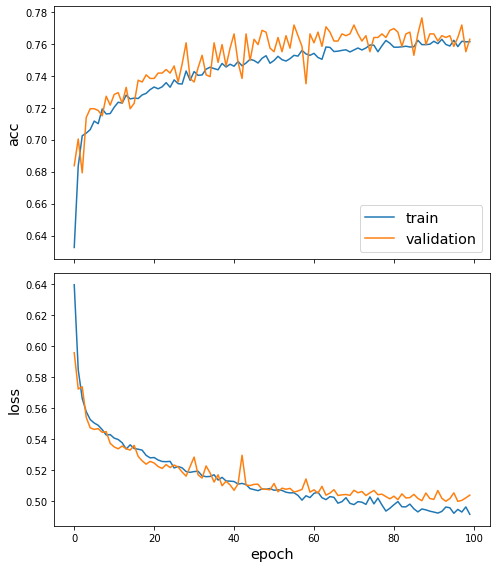

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

898/898 [==============================] - 3s 4ms/step - loss: 0.5037 - acc: 0.7628

Test Set Metrics:
	loss: 0.5037
	acc: 0.7628
